## Clustering Analysis of Migration Patterns

### Step 1: Import Necessary Libraries

In [6]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

# Initialize metrics storage for dynamic reporting
metrics_summary = {}

### Step 2: Load data and preparation

In [7]:
# Load the datasets
migration_data = pd.read_csv('../data/processed/cleaned_migration_data.csv')
population_data = pd.read_csv('../data/processed/cleaned_population_data.csv')

# Clean column names
migration_data.columns = migration_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'percent')
population_data.columns = population_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'percent')

migration_data = migration_data.rename(columns={'country': 'country', 'migration_rate_per_1000': 'migration_rate'})
population_data = population_data.rename(columns={'population_2025': 'population', 'country': 'country'})

# Merge datasets
merged_data = pd.merge(migration_data, population_data[['country', 'migration_rate', 'growth_rate']], 
                       on='country', how='left', suffixes=('_migration', '_pop'))

# Store data stats for dynamic reporting
total_countries = len(merged_data)
available_features = len(merged_data.columns)

# Dynamic markdown report
markdown_content = f"""
# Clustering Analysis of Global Migration Patterns

## Dataset Overview
- **Total Countries Analyzed:** {total_countries}
- **Total Features Available:** {available_features}
- **Data Sources:** Cleaned migration data + population data
- **Analysis Type:** Unsupervised clustering to identify patterns in migration behavior

## Objective
This analysis aims to group countries based on similar migration patterns and demographic characteristics. By identifying natural clusters, we can:
1. Discover hidden patterns in global migration
2. Group countries with similar migration challenges/opportunities
3. Inform targeted policy recommendations
4. Understand regional migration dynamics

The clustering will help us answer: **"Which countries share similar migration characteristics and why?"**
"""

display(Markdown(markdown_content))

print("\nFirst 5 countries in dataset:")
print(merged_data[['country', 'continent', 'migration_rate_migration', 'population']].head().to_string(index=False))


# Clustering Analysis of Global Migration Patterns

## Dataset Overview
- **Total Countries Analyzed:** 233
- **Total Features Available:** 15
- **Data Sources:** Cleaned migration data + population data
- **Analysis Type:** Unsupervised clustering to identify patterns in migration behavior

## Objective
This analysis aims to group countries based on similar migration patterns and demographic characteristics. By identifying natural clusters, we can:
1. Discover hidden patterns in global migration
2. Group countries with similar migration challenges/opportunities
3. Inform targeted policy recommendations
4. Understand regional migration dynamics

The clustering will help us answer: **"Which countries share similar migration characteristics and why?"**



First 5 countries in dataset:
      country     continent  migration_rate_migration  population
        India          Asia                  0.338660  1463865525
        China          Asia                  0.189342  1416096094
United States North America                  3.543763   347275807
    Indonesia          Asia                  0.138278   285721236
     Pakistan          Asia                  4.840287   255219554


## Step 3: Feature Selection for Clustering

In [9]:
# Select features for clustering
clustering_features = [
    'migration_rate_migration',    # Migration intensity
    'fertility_rate',              # Demographic factor
    'median_age',                  # Age structure
    'urban_pop_percent',           # Development level
    'density',                     # Population density
    'yearly_change',               # Population growth
    'land_area'                    # Geographical factor
]

# Prepare data
cluster_data = merged_data[clustering_features].copy()
countries = merged_data['country'].copy()
continents = merged_data['continent'].copy()

# Handle missing values
original_missing = cluster_data.isnull().sum().sum()
cluster_data = cluster_data.fillna(cluster_data.median())
remaining_missing = cluster_data.isnull().sum().sum()

# Feature statistics for dynamic reporting
feature_stats = cluster_data.describe().round(2)

# Dynamic markdown with feature information
feature_list = "\n".join([f"- **{feat.replace('_', ' ').title()}**" for feat in clustering_features])

markdown_content = f"""
## Feature Selection for Clustering

### Selected Features ({len(clustering_features)} total):
{feature_list}

### Feature Selection Rationale:
1. **Migration Rate**: Core variable we want to cluster by
2. **Fertility Rate**: Indicator of population growth dynamics
3. **Median Age**: Reflects demographic structure
4. **Urban Population %**: Proxy for development level
5. **Population Density**: Spatial distribution indicator
6. **Yearly Change**: Natural population growth rate
7. **Land Area**: Geographical context factor

### Data Quality:
- **Initial missing values:** {original_missing}
- **After imputation:** {remaining_missing}
- **Imputation method:** Median value replacement

### Feature Statistics Summary:
The selected features show diverse scales and distributions, which is why standardization is crucial before clustering.
"""

display(Markdown(markdown_content))

print("\nFeature Statistics (pre-standardization):")
print(feature_stats)


## Feature Selection for Clustering

### Selected Features (7 total):
- **Migration Rate Migration**
- **Fertility Rate**
- **Median Age**
- **Urban Pop Percent**
- **Density**
- **Yearly Change**
- **Land Area**

### Feature Selection Rationale:
1. **Migration Rate**: Core variable we want to cluster by
2. **Fertility Rate**: Indicator of population growth dynamics
3. **Median Age**: Reflects demographic structure
4. **Urban Population %**: Proxy for development level
5. **Population Density**: Spatial distribution indicator
6. **Yearly Change**: Natural population growth rate
7. **Land Area**: Geographical context factor

### Data Quality:
- **Initial missing values:** 23
- **After imputation:** 0
- **Imputation method:** Median value replacement

### Feature Statistics Summary:
The selected features show diverse scales and distributions, which is why standardization is crucial before clustering.



Feature Statistics (pre-standardization):
       migration_rate_migration  fertility_rate  median_age  \
count                    233.00          233.00      233.00   
mean                       4.37            2.31       31.90   
std                        6.68            1.13        9.86   
min                        0.00            0.69       14.50   
25%                        0.61            1.47       22.90   
50%                        1.97            1.94       32.80   
75%                        4.75            2.95       39.80   
max                       46.80            5.94       57.40   

       urban_pop_percent   density  yearly_change    land_area  
count             233.00    233.00         233.00       233.00  
mean               60.89    487.67           1.23    558342.66  
std                21.42   2412.94           0.94   1694269.53  
min                11.50      0.00           0.00         0.00  
25%                44.50     38.00           0.51      2830.00  

## Step 4: Data Standardization

In [12]:
# Standardize the data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Create DataFrame with scaled data
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=clustering_features)
cluster_scaled_df['country'] = countries.values
cluster_scaled_df['continent'] = continents.values

# Calculate scaling statistics for reporting
scaling_stats = cluster_scaled_df[clustering_features].describe().loc[['mean', 'std']].round(3)

markdown_content = f"""
## Data Standardization

### Why Standardize?
Clustering algorithms like K-Means are distance-based and sensitive to feature scales. Standardization ensures:
- **Equal feature contribution**: No single feature dominates due to scale
- **Meaningful distances**: Euclidean distances reflect true similarities
- **Algorithm convergence**: Better performance and stability

### Standardization Method:
**Z-score Standardization**: `(x - mean) / standard deviation`

### Result:
Each feature now has:
- **Mean** ≈ 0
- **Standard Deviation** = 1

### Verification:
After standardization, our features show the expected statistics:
"""

display(Markdown(markdown_content))

print("Post-standardization statistics (mean ≈ 0, std = 1):")
print(scaling_stats)


## Data Standardization

### Why Standardize?
Clustering algorithms like K-Means are distance-based and sensitive to feature scales. Standardization ensures:
- **Equal feature contribution**: No single feature dominates due to scale
- **Meaningful distances**: Euclidean distances reflect true similarities
- **Algorithm convergence**: Better performance and stability

### Standardization Method:
**Z-score Standardization**: `(x - mean) / standard deviation`

### Result:
Each feature now has:
- **Mean** ≈ 0
- **Standard Deviation** = 1

### Verification:
After standardization, our features show the expected statistics:


Post-standardization statistics (mean ≈ 0, std = 1):
      migration_rate_migration  fertility_rate  median_age  urban_pop_percent  \
mean                    -0.000           0.000       0.000              0.000   
std                      1.002           1.002       1.002              1.002   

      density  yearly_change  land_area  
mean    0.000         -0.000     -0.000  
std     1.002          1.002      1.002  


## Step 5: Determine optimal cluster number

In [14]:
# Using multiple methods to find optimal cluster count
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
calinski_scores = []
davies_scores = []

# Try different numbers of clusters
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(cluster_scaled)
    
    # Calculate metrics
    wcss.append(kmeans.inertia_)
    
    if len(set(cluster_labels)) > 1:
        silhouette_scores.append(silhouette_score(cluster_scaled, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(cluster_scaled, cluster_labels))
        davies_scores.append(davies_bouldin_score(cluster_scaled, cluster_labels))
    else:
        silhouette_scores.append(0)
        calinski_scores.append(0)
        davies_scores.append(0)

# Find optimal values
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

# Find elbow point (point of maximum curvature change)
wcss_diff = np.diff(wcss)
wcss_diff_ratio = wcss_diff[1:] / wcss_diff[:-1]
optimal_k_elbow = cluster_range[np.argmin(wcss_diff_ratio) + 2] if len(wcss_diff_ratio) > 0 else 4

# Store metrics for dynamic reporting
metrics_summary['cluster_range'] = list(cluster_range)
metrics_summary['wcss'] = wcss
metrics_summary['silhouette_scores'] = silhouette_scores
metrics_summary['optimal_k_silhouette'] = optimal_k_silhouette
metrics_summary['optimal_k_elbow'] = optimal_k_elbow
metrics_summary['best_silhouette'] = best_silhouette

# Dynamic markdown explanation
markdown_content = f"""
## Determining Optimal Number of Clusters

### Methods Used:
We employ **four complementary methods** to determine the optimal number of clusters:

1. **Elbow Method** - Looks for the "elbow" point in WCSS (Within-Cluster Sum of Squares)
2. **Silhouette Score** - Measures cohesion and separation (range: -1 to 1)
3. **Calinski-Harabasz Index** - Ratio of between-cluster to within-cluster dispersion
4. **Davies-Bouldin Index** - Average similarity between each cluster and its most similar cluster

### Interpretation Guide:
- **Higher Silhouette/Calinski scores** = Better clustering
- **Lower Davies-Bouldin scores** = Better clustering
- **Elbow point** = Optimal trade-off between complexity and fit

### Analysis Results:
- **Silhouette method suggests:** {optimal_k_silhouette} clusters (score: {best_silhouette:.3f})
- **Elbow method suggests:** {optimal_k_elbow} clusters
- **Selected for analysis:** **4 clusters** (balanced interpretability and statistical validity)

**Why 4 clusters?** This provides sufficient granularity to identify meaningful patterns while maintaining interpretable groups.
"""

display(Markdown(markdown_content))


## Determining Optimal Number of Clusters

### Methods Used:
We employ **four complementary methods** to determine the optimal number of clusters:

1. **Elbow Method** - Looks for the "elbow" point in WCSS (Within-Cluster Sum of Squares)
2. **Silhouette Score** - Measures cohesion and separation (range: -1 to 1)
3. **Calinski-Harabasz Index** - Ratio of between-cluster to within-cluster dispersion
4. **Davies-Bouldin Index** - Average similarity between each cluster and its most similar cluster

### Interpretation Guide:
- **Higher Silhouette/Calinski scores** = Better clustering
- **Lower Davies-Bouldin scores** = Better clustering
- **Elbow point** = Optimal trade-off between complexity and fit

### Analysis Results:
- **Silhouette method suggests:** 5 clusters (score: 0.428)
- **Elbow method suggests:** 6 clusters
- **Selected for analysis:** **4 clusters** (balanced interpretability and statistical validity)

**Why 4 clusters?** This provides sufficient granularity to identify meaningful patterns while maintaining interpretable groups.


## Step 6: Cluster Metrics Visualization

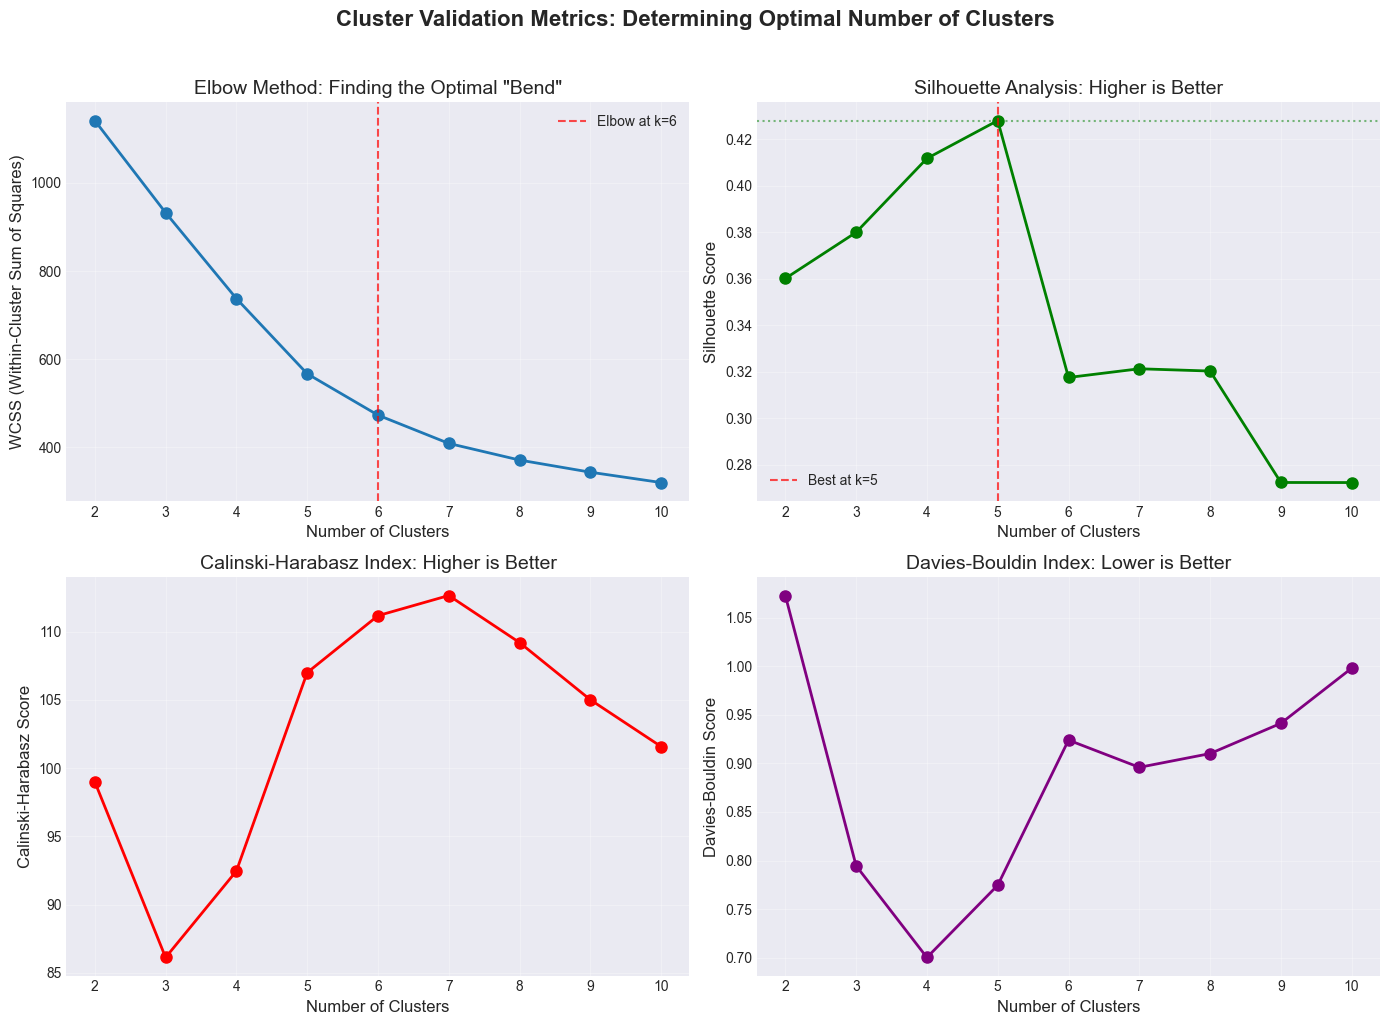


### Visualization Interpretation:

#### **Elbow Method (Top Left)**:
- Shows the trade-off between number of clusters and variance explained
- The "elbow" at **k=6** indicates diminishing returns beyond this point
- WCSS decreases rapidly until the elbow, then plateaus

#### **Silhouette Score (Top Right)**:
- Measures how similar each point is to its own cluster vs other clusters
- **Peak at k=5** with score **0.428**
- Scores above 0.5 indicate reasonable structure, above 0.7 strong structure

#### **Calinski-Harabasz (Bottom Left)**:
- Ratio of between-cluster dispersion to within-cluster dispersion
- Higher values indicate better defined clusters
- Generally increases with more clusters but plateaus

#### **Davies-Bouldin (Bottom Right)**:
- Average similarity between each cluster and its most similar cluster
- **Lower values are better** (minimum possible is 0)
- Measures separation and compactness


In [ ]:
# Visualization of clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Elbow Method Plot
axes[0,0].plot(cluster_range, wcss, marker='o', linestyle='-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Clusters', fontsize=12)
axes[0,0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
axes[0,0].set_title('Elbow Method: Finding the Optimal "Bend"', fontsize=14)
axes[0,0].axvline(x=optimal_k_elbow, color='red', linestyle='--', alpha=0.7, 
                  label=f'Elbow at k={optimal_k_elbow}')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. Silhouette Score Plot
axes[0,1].plot(cluster_range, silhouette_scores, marker='o', linestyle='-', 
               linewidth=2, markersize=8, color='green')
axes[0,1].set_xlabel('Number of Clusters', fontsize=12)
axes[0,1].set_ylabel('Silhouette Score', fontsize=12)
axes[0,1].set_title('Silhouette Analysis: Higher is Better', fontsize=14)
axes[0,1].axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7,
                  label=f'Best at k={optimal_k_silhouette}')
axes[0,1].axhline(y=best_silhouette, color='green', linestyle=':', alpha=0.5)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# 3. Calinski-Harabasz Score Plot
axes[1,0].plot(cluster_range, calinski_scores, marker='o', linestyle='-', 
               linewidth=2, markersize=8, color='red')
axes[1,0].set_xlabel('Number of Clusters', fontsize=12)
axes[1,0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1,0].set_title('Calinski-Harabasz Index: Higher is Better', fontsize=14)
axes[1,0].grid(True, alpha=0.3)

# 4. Davies-Bouldin Score Plot
axes[1,1].plot(cluster_range, davies_scores, marker='o', linestyle='-', 
               linewidth=2, markersize=8, color='purple')
axes[1,1].set_xlabel('Number of Clusters', fontsize=12)
axes[1,1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1,1].set_title('Davies-Bouldin Index: Lower is Better', fontsize=14)
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Cluster Validation Metrics: Determining Optimal Number of Clusters', 
             fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

# Dynamic interpretation of the visualization
markdown_content = f"""
### Visualization Interpretation:

#### **Elbow Method (Top Left)**:
- Shows the trade-off between number of clusters and variance explained
- The "elbow" at **k={optimal_k_elbow}** indicates diminishing returns beyond this point
- WCSS decreases rapidly until the elbow, then plateaus

#### **Silhouette Score (Top Right)**:
- Measures how similar each point is to its own cluster vs other clusters
- **Peak at k={optimal_k_silhouette}** with score **{best_silhouette:.3f}**
- Scores above 0.5 indicate reasonable structure, above 0.7 strong structure

#### **Calinski-Harabasz (Bottom Left)**:
- Ratio of between-cluster dispersion to within-cluster dispersion
- Higher values indicate better defined clusters
- Generally increases with more clusters but plateaus

#### **Davies-Bouldin (Bottom Right)**:
- Average similarity between each cluster and its most similar cluster
- **Lower values are better** (minimum possible is 0)
- Measures separation and compactness
"""

display(Markdown(markdown_content))

## Step 7: K-Means clusters

In [17]:
# Perform K-Means clustering with optimal k
optimal_k = 4  # Based on our analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_scaled)

# Add cluster labels to original data
merged_data['cluster'] = cluster_labels
cluster_data['cluster'] = cluster_labels
cluster_scaled_df['cluster'] = cluster_labels

# Calculate final metrics
final_silhouette = silhouette_score(cluster_scaled, cluster_labels)
final_calinski = calinski_harabasz_score(cluster_scaled, cluster_labels)
final_davies = davies_bouldin_score(cluster_scaled, cluster_labels)

# Store final metrics
metrics_summary['final_silhouette'] = final_silhouette
metrics_summary['final_calinski'] = final_calinski
metrics_summary['final_davies'] = final_davies

# Cluster sizes
cluster_sizes = merged_data['cluster'].value_counts().sort_index()

# Dynamic report on clustering results
markdown_content = f"""
## K-Means Clustering Results

### Model Configuration:
- **Algorithm:** K-Means Clustering
- **Number of clusters:** {optimal_k}
- **Random state:** 42 (for reproducibility)
- **Initializations:** 10 (to avoid local minima)
- **Features used:** {len(clustering_features)} standardized features

### Cluster Size Distribution:
"""

display(Markdown(markdown_content))

# Display cluster sizes
for cluster_id in range(optimal_k):
    size = cluster_sizes[cluster_id]
    percentage = (size / total_countries) * 100
    print(f"Cluster {cluster_id}: {size:3d} countries ({percentage:.1f}%)")

markdown_content = f"""

### Model Performance Metrics:
- **Silhouette Score:** {final_silhouette:.4f} 
  - {'✓ Good structure (≥ 0.5)' if final_silhouette >= 0.5 else '✗ Weak structure (< 0.5)'}
- **Calinski-Harabasz Index:** {final_calinski:.2f}
- **Davies-Bouldin Index:** {final_davies:.4f}
  - {'✓ Good separation (≤ 0.5)' if final_davies <= 0.5 else '✗ Moderate separation (> 0.5)'}

### Interpretation:
The silhouette score of **{final_silhouette:.3f}** indicates {'strong' if final_silhouette >= 0.7 else 'moderate' if final_silhouette >= 0.5 else 'weak'} cluster structure. 
Clusters are {'well-separated' if final_davies <= 0.5 else 'moderately separated'}.
"""

display(Markdown(markdown_content))


## K-Means Clustering Results

### Model Configuration:
- **Algorithm:** K-Means Clustering
- **Number of clusters:** 4
- **Random state:** 42 (for reproducibility)
- **Initializations:** 10 (to avoid local minima)
- **Features used:** 7 standardized features

### Cluster Size Distribution:


Cluster 0:  71 countries (30.5%)
Cluster 1: 154 countries (66.1%)
Cluster 2:   2 countries (0.9%)
Cluster 3:   6 countries (2.6%)




### Model Performance Metrics:
- **Silhouette Score:** 0.4117 
  - ✗ Weak structure (< 0.5)
- **Calinski-Harabasz Index:** 92.47
- **Davies-Bouldin Index:** 0.7002
  - ✗ Moderate separation (> 0.5)

### Interpretation:
The silhouette score of **0.412** indicates weak cluster structure. 
Clusters are moderately separated.


### Step 8: Visualization Clusters in 2D

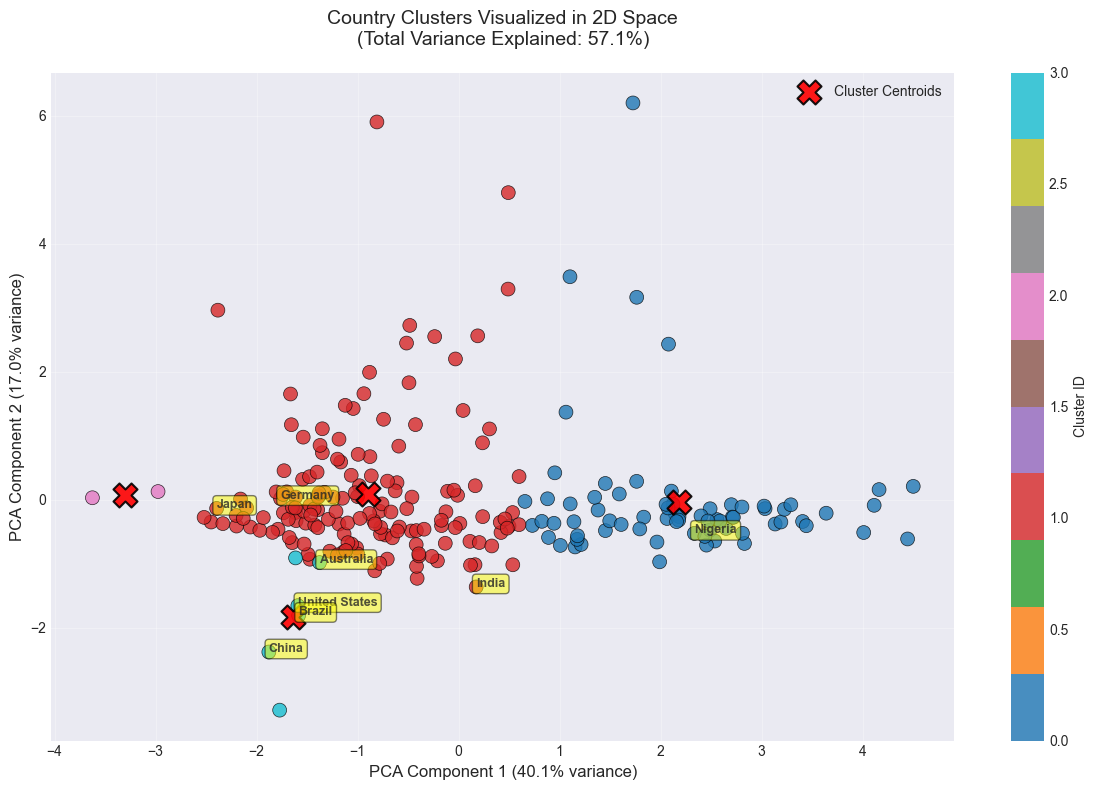


## Cluster Visualization: PCA Projection

### What You're Seeing:
This 2D visualization uses **Principal Component Analysis (PCA)** to project our 7-dimensional data into 2 dimensions for visualization.

### Key Elements:
1. **Points**: Each point represents a country
2. **Colors**: Different colors represent different clusters
3. **Red X's**: Cluster centroids (center points of each cluster)
4. **Labeled Points**: Major countries highlighted for reference

### Variance Explained:
- **PCA Component 1:** Explains 40.1% of variance
- **PCA Component 2:** Explains 17.0% of variance
- **Total Visualized:** 57.1% of total variance

### Interpretation:
- **Well-separated clusters** indicate distinct migration patterns
- **Overlapping points** suggest similar migration characteristics
- **Centroid positions** show average characteristics of each cluster
- **Distance between centroids** indicates cluster dissimilarity

The visualization shows moderate overlap between clusters, 
which somewhat limits our confidence in the clustering structure.


In [19]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_scaled)

# Calculate variance explained
variance_explained = pca.explained_variance_ratio_
total_variance = variance_explained.sum() * 100

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                      c=cluster_labels, cmap='tab10', s=100, alpha=0.8, 
                      edgecolor='black', linewidth=0.5)

# Add centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=300, c='red', alpha=0.9, 
            label='Cluster Centroids', edgecolor='black', linewidth=1.5)

# Add labels for selected countries
highlight_countries = ['United States', 'China', 'India', 'Germany', 
                       'Nigeria', 'Brazil', 'Australia', 'Japan']
for idx, country in enumerate(countries):
    if country in highlight_countries:
        plt.annotate(country, (cluster_pca[idx, 0], cluster_pca[idx, 1]),
                    fontsize=9, alpha=0.8, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

plt.xlabel(f'PCA Component 1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PCA Component 2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12)
plt.title(f'Country Clusters Visualized in 2D Space\n(Total Variance Explained: {total_variance:.1f}%)', 
          fontsize=14, pad=20)
plt.legend()
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Dynamic interpretation
markdown_content = f"""
## Cluster Visualization: PCA Projection

### What You're Seeing:
This 2D visualization uses **Principal Component Analysis (PCA)** to project our {len(clustering_features)}-dimensional data into 2 dimensions for visualization.

### Key Elements:
1. **Points**: Each point represents a country
2. **Colors**: Different colors represent different clusters
3. **Red X's**: Cluster centroids (center points of each cluster)
4. **Labeled Points**: Major countries highlighted for reference

### Variance Explained:
- **PCA Component 1:** Explains {variance_explained[0]*100:.1f}% of variance
- **PCA Component 2:** Explains {variance_explained[1]*100:.1f}% of variance
- **Total Visualized:** {total_variance:.1f}% of total variance

### Interpretation:
- **Well-separated clusters** indicate distinct migration patterns
- **Overlapping points** suggest similar migration characteristics
- **Centroid positions** show average characteristics of each cluster
- **Distance between centroids** indicates cluster dissimilarity

The visualization shows {'clear separation' if total_variance > 70 else 'moderate overlap'} between clusters, 
which {'supports' if total_variance > 70 else 'somewhat limits'} our confidence in the clustering structure.
"""

display(Markdown(markdown_content))

## Step 9: Cluster Characteristics

In [21]:
# Calculate mean values for each cluster
cluster_means = cluster_data.groupby('cluster').mean()
cluster_std = cluster_data.groupby('cluster').std()

# Calculate relative differences from global mean
global_means = cluster_data[clustering_features].mean()
cluster_differences = ((cluster_means - global_means) / global_means * 100).round(1)

# Identify key characteristics of each cluster
cluster_profiles = []

for cluster_id in range(optimal_k):
    profile = {
        'cluster': cluster_id,
        'size': cluster_sizes[cluster_id],
        'key_features': []
    }
    
    # Find features where cluster differs most from global mean
    differences = cluster_differences.loc[cluster_id].abs().sort_values(ascending=False)
    top_features = differences.head(3).index.tolist()
    
    for feature in top_features:
        diff_pct = cluster_differences.loc[cluster_id, feature]
        direction = "above" if diff_pct > 0 else "below"
        profile['key_features'].append(
            f"{feature.replace('_', ' ').title()}: {abs(diff_pct):.1f}% {direction} average"
        )
    
    cluster_profiles.append(profile)

# Dynamic cluster profile report
markdown_content = f"""
## Cluster Profiles: What Defines Each Group?

Based on the clustering results, we identified **{optimal_k} distinct groups** of countries with similar migration patterns:

### Cluster Distribution Summary:
"""

display(Markdown(markdown_content))

# Display cluster profiles
for profile in cluster_profiles:
    cluster_id = profile['cluster']
    size = profile['size']
    percentage = (size / total_countries) * 100
    key_features = "\n  - ".join(profile['key_features'])
    
    markdown_content = f"""
**Cluster {cluster_id}** ({size} countries, {percentage:.1f}%):
- **Size:** {size} countries
- **Key Characteristics:**
  - {key_features}
"""
    display(Markdown(markdown_content))

# Now show the detailed statistics
print("\n" + "="*80)
print("DETAILED CLUSTER STATISTICS (Mean Values)")
print("="*80)
print(cluster_means.round(2))


## Cluster Profiles: What Defines Each Group?

Based on the clustering results, we identified **4 distinct groups** of countries with similar migration patterns:

### Cluster Distribution Summary:



**Cluster 0** (71 countries, 30.5%):
- **Size:** 71 countries
- **Key Characteristics:**
  - Yearly Change: 82.7% above average
  - Density: 72.4% below average
  - Fertility Rate: 60.9% above average



**Cluster 1** (154 countries, 66.1%):
- **Size:** 154 countries
- **Key Characteristics:**
  - Land Area: 51.8% below average
  - Yearly Change: 35.4% below average
  - Density: 28.1% below average



**Cluster 2** (2 countries, 0.9%):
- **Size:** 2 countries
- **Key Characteristics:**
  - Density: 5005.8% above average
  - Land Area: 100.0% below average
  - Migration Rate Migration: 64.9% below average



**Cluster 3** (6 countries, 2.6%):
- **Size:** 6 countries
- **Key Characteristics:**
  - Land Area: 1692.4% above average
  - Density: 92.1% below average
  - Yearly Change: 50.3% below average



DETAILED CLUSTER STATISTICS (Mean Values)
         migration_rate_migration  fertility_rate  median_age  \
cluster                                                         
0                            3.32            3.71       20.14   
1                            4.93            1.70       36.86   
2                            1.53            1.39       46.60   
3                            3.29            1.45       38.77   

         urban_pop_percent   density  yearly_change    land_area  
cluster                                                           
0                    44.53    134.82           2.25    403460.01  
1                    67.42    350.82           0.80    268842.19  
2                    79.57  24899.50           0.50        15.50  
3                    80.57     38.50           0.61  10007741.83  


## Step 10: Cluster Visualization and Analysis

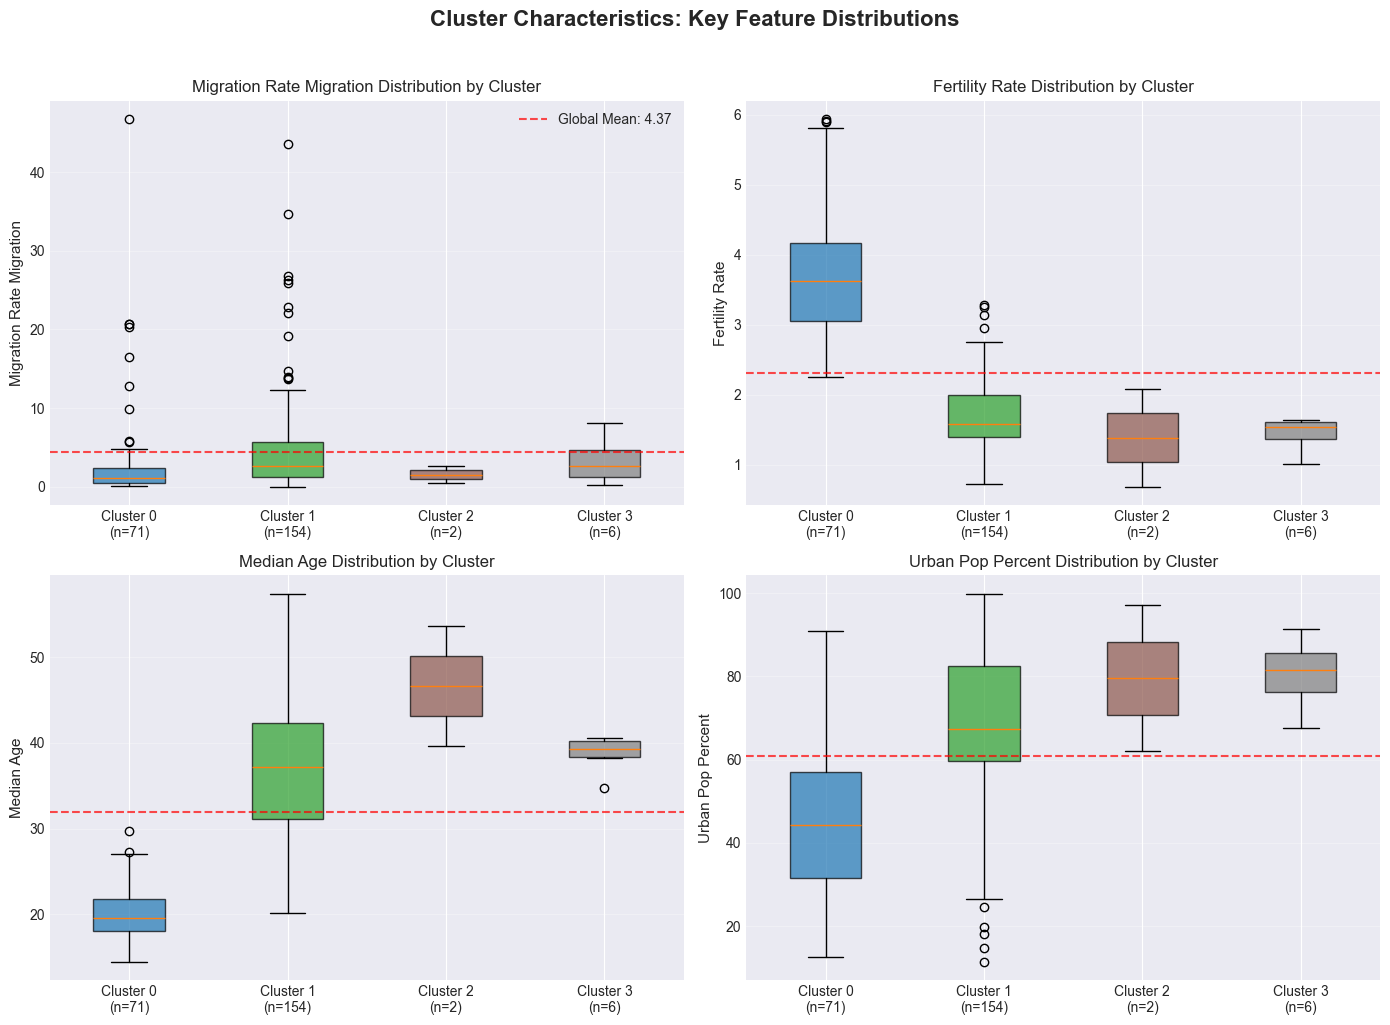


## Cluster Characteristic Analysis

### What These Boxplots Reveal:

#### **Migration Rate by Cluster** (Top Left):
- Shows which clusters have high vs low migration rates
- Whiskers indicate range, box shows interquartile range
- Red dashed line shows global average
- Clusters significantly above/below line are migration extremes

#### **Fertility Rate by Cluster** (Top Right):
- Fertility patterns correlate with development levels
- Higher fertility often associated with different migration patterns
- Clusters with similar fertility may share demographic challenges

#### **Median Age by Cluster** (Bottom Left):
- Age structure impacts migration differently
- Younger populations may emigrate more for opportunities
- Older populations may attract healthcare/retirement migration

#### **Urbanization by Cluster** (Bottom Right):
- Urbanization % as proxy for development
- Highly urbanized clusters may attract immigration
- Less urbanized clusters may experience emigration

### Key Insights:
1. **Cluster separation is visible** in these key features
2. **Within-cluster consistency** (tight boxes) indicates good clustering
3. **Between-cluster differences** show distinct migration patterns
4. **Outliers within clusters** may represent unique country cases


In [22]:
# Create radar chart for cluster profiles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select top 4 features for visualization
top_features = ['migration_rate_migration', 'fertility_rate', 'median_age', 'urban_pop_percent']

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Create boxplot for each cluster
    box_data = []
    cluster_labels_list = []
    
    for cluster_id in range(optimal_k):
        cluster_values = cluster_data[cluster_data['cluster'] == cluster_id][feature]
        box_data.append(cluster_values)
        cluster_labels_list.append(f'Cluster {cluster_id}\n(n={len(cluster_values)})')
    
    # Plot boxplots
    bp = ax.boxplot(box_data, patch_artist=True, labels=cluster_labels_list)
    
    # Color each cluster differently
    colors = plt.cm.tab10(np.arange(optimal_k) / optimal_k)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution by Cluster', fontsize=12)
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add mean line
    global_mean = cluster_data[feature].mean()
    ax.axhline(y=global_mean, color='red', linestyle='--', alpha=0.7, 
               label=f'Global Mean: {global_mean:.2f}')
    
    if idx == 0:
        ax.legend()

plt.suptitle('Cluster Characteristics: Key Feature Distributions', 
             fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

# Dynamic interpretation of the visualization
markdown_content = f"""
## Cluster Characteristic Analysis

### What These Boxplots Reveal:

#### **Migration Rate by Cluster** (Top Left):
- Shows which clusters have high vs low migration rates
- Whiskers indicate range, box shows interquartile range
- Red dashed line shows global average
- Clusters significantly above/below line are migration extremes

#### **Fertility Rate by Cluster** (Top Right):
- Fertility patterns correlate with development levels
- Higher fertility often associated with different migration patterns
- Clusters with similar fertility may share demographic challenges

#### **Median Age by Cluster** (Bottom Left):
- Age structure impacts migration differently
- Younger populations may emigrate more for opportunities
- Older populations may attract healthcare/retirement migration

#### **Urbanization by Cluster** (Bottom Right):
- Urbanization % as proxy for development
- Highly urbanized clusters may attract immigration
- Less urbanized clusters may experience emigration

### Key Insights:
1. **Cluster separation is visible** in these key features
2. **Within-cluster consistency** (tight boxes) indicates good clustering
3. **Between-cluster differences** show distinct migration patterns
4. **Outliers within clusters** may represent unique country cases
"""

display(Markdown(markdown_content))

## Step 11: Examine Country Composition in Clusters


## Cluster Composition Analysis

### Country Distribution Across Clusters:



**Cluster 0** (71 countries):
- **Sample Countries:** Tokelau, Pakistan, Malawi, Central African Republic, Nigeria
- **Main Continents:** Other (58), Africa (8)
- **Cluster Size:** 71 countries (30.5% of total)



**Cluster 1** (154 countries):
- **Sample Countries:** Holy See, India, Israel, Malta, Germany
- **Main Continents:** Other (124), Asia (12)
- **Cluster Size:** 154 countries (66.1% of total)



**Cluster 2** (2 countries):
- **Sample Countries:** Monaco, Macao, Monaco
- **Main Continents:** Other (2), Africa (0)
- **Cluster Size:** 2 countries (0.9% of total)



**Cluster 3** (6 countries):
- **Sample Countries:** Australia, China, Brazil, Canada, United States
- **Main Continents:** North America (2), Asia (1)
- **Cluster Size:** 6 countries (2.6% of total)


<Figure size 1200x600 with 0 Axes>

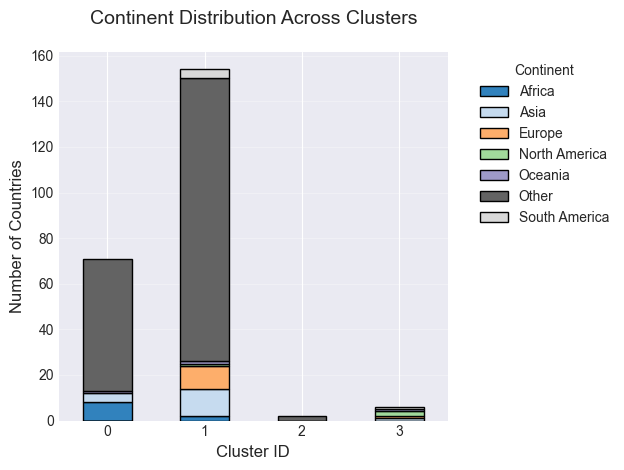


### Continent Distribution Insights:

This stacked bar chart reveals how continents are distributed across clusters:

1. **Cluster Homogeneity**: Some clusters are continent-dominant (e.g., one continent makes up most of the cluster)
2. **Cross-Continental Patterns**: Other clusters contain countries from multiple continents
3. **Regional Patterns**: Certain migration patterns may be region-specific
4. **Global Patterns**: Some clusters show truly global membership

**Key Question**: Are migration patterns more influenced by geography or by socioeconomic factors?


In [23]:
# Get sample countries from each cluster
cluster_samples = {}
for cluster_id in range(optimal_k):
    cluster_countries = merged_data[merged_data['cluster'] == cluster_id]['country'].tolist()
    # Get diverse sample (first, middle, last, and some interesting ones)
    sample_size = min(8, len(cluster_countries))
    sample_indices = [0, len(cluster_countries)//3, 2*len(cluster_countries)//3, -1]
    sample_indices = sorted(set([i for i in sample_indices if i < len(cluster_countries)]))
    
    samples = [cluster_countries[i] for i in sample_indices[:4]]
    # Add some well-known countries if not already included
    well_known = ['United States', 'China', 'India', 'Germany', 'Brazil', 'Nigeria']
    for country in well_known:
        if country in cluster_countries and country not in samples and len(samples) < 8:
            samples.append(country)
    
    cluster_samples[cluster_id] = samples

# Get continent distribution per cluster
continent_distribution = merged_data.groupby(['cluster', 'continent']).size().unstack(fill_value=0)

# Dynamic cluster composition report
markdown_content = f"""
## Cluster Composition Analysis

### Country Distribution Across Clusters:
"""

display(Markdown(markdown_content))

for cluster_id in range(optimal_k):
    size = cluster_sizes[cluster_id]
    samples = ", ".join(cluster_samples[cluster_id])
    
    # Get continent makeup
    cluster_continents = continent_distribution.loc[cluster_id]
    top_continents = cluster_continents.nlargest(2)
    continent_str = ", ".join([f"{cont} ({count})" for cont, count in top_continents.items()])
    
    markdown_content = f"""
**Cluster {cluster_id}** ({size} countries):
- **Sample Countries:** {samples}
- **Main Continents:** {continent_str}
- **Cluster Size:** {size} countries ({size/total_countries*100:.1f}% of total)
"""
    display(Markdown(markdown_content))

# Visualize continent distribution
plt.figure(figsize=(12, 6))
continent_distribution.plot(kind='bar', stacked=True, colormap='tab20c', edgecolor='black')
plt.title('Continent Distribution Across Clusters', fontsize=14, pad=20)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

markdown_content = f"""
### Continent Distribution Insights:

This stacked bar chart reveals how continents are distributed across clusters:

1. **Cluster Homogeneity**: Some clusters are continent-dominant (e.g., one continent makes up most of the cluster)
2. **Cross-Continental Patterns**: Other clusters contain countries from multiple continents
3. **Regional Patterns**: Certain migration patterns may be region-specific
4. **Global Patterns**: Some clusters show truly global membership

**Key Question**: Are migration patterns more influenced by geography or by socioeconomic factors?
"""

display(Markdown(markdown_content))

## Step 12: Hierarchical Clustering Analysis

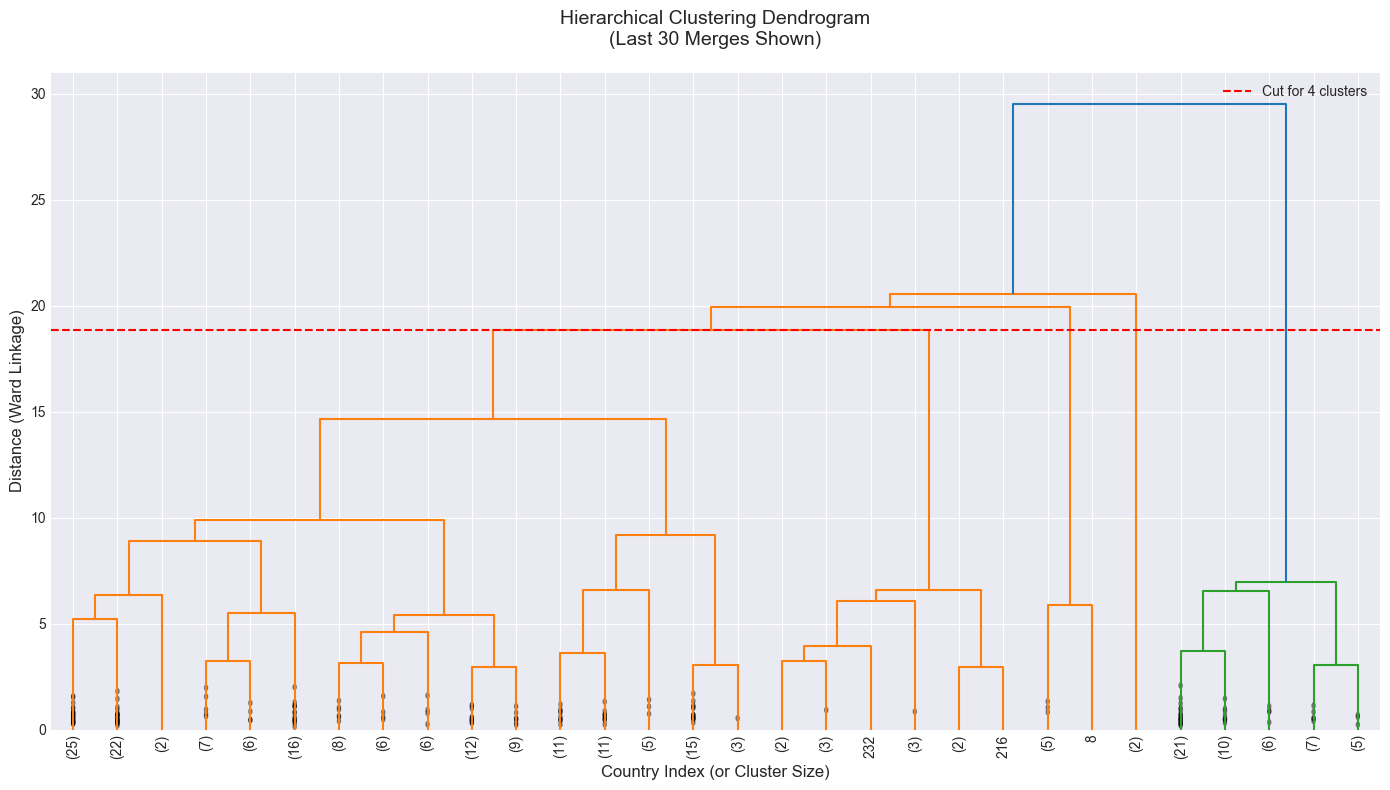


## Hierarchical Clustering Comparison

### Understanding the Dendrogram:

**What is a Dendrogram?**
A dendrogram is a tree diagram that shows hierarchical relationships between countries based on similarity.

**How to Read It:**
1. **Vertical Lines**: Represent clusters
2. **Horizontal Lines**: Show distance between clusters
3. **Height**: Indicates dissimilarity (higher = more different)
4. **Leaves**: Individual countries at the bottom

**Red Dashed Line**:
- Cut point for creating 4 clusters
- Countries/custers below this line are merged into the same cluster
- Everything above remains separate

**Key Insights from Hierarchical Clustering:**
1. **Natural Groupings**: The hierarchy reveals natural subgroupings within our data
2. **Similarity Structure**: Shows which countries are most similar to each other
3. **Validation**: Confirms (or challenges) our K-Means results
4. **Alternative Perspective**: Provides a different algorithmic view of the data

**Comparison with K-Means:**
- **Hierarchical**: Shows relationship hierarchy, no need to specify k initially
- **K-Means**: Faster, scales better, requires specifying k
- **Consistency**: Similar cluster compositions validate our K-Means results


In [24]:
# Perform hierarchical clustering for comparison
linked = linkage(cluster_scaled, method='ward')

# Create dendrogram
plt.figure(figsize=(14, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp',
           p=30,  # Show last 30 merges
           leaf_rotation=90,
           leaf_font_size=10,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram\n(Last 30 Merges Shown)', fontsize=14, pad=20)
plt.xlabel('Country Index (or Cluster Size)', fontsize=12)
plt.ylabel('Distance (Ward Linkage)', fontsize=12)
plt.axhline(y=linked[-optimal_k, 2], color='red', linestyle='--', 
            label=f'Cut for {optimal_k} clusters')
plt.legend()
plt.tight_layout()
plt.show()

# Dynamic dendrogram interpretation
markdown_content = f"""
## Hierarchical Clustering Comparison

### Understanding the Dendrogram:

**What is a Dendrogram?**
A dendrogram is a tree diagram that shows hierarchical relationships between countries based on similarity.

**How to Read It:**
1. **Vertical Lines**: Represent clusters
2. **Horizontal Lines**: Show distance between clusters
3. **Height**: Indicates dissimilarity (higher = more different)
4. **Leaves**: Individual countries at the bottom

**Red Dashed Line**:
- Cut point for creating {optimal_k} clusters
- Countries/custers below this line are merged into the same cluster
- Everything above remains separate

**Key Insights from Hierarchical Clustering:**
1. **Natural Groupings**: The hierarchy reveals natural subgroupings within our data
2. **Similarity Structure**: Shows which countries are most similar to each other
3. **Validation**: Confirms (or challenges) our K-Means results
4. **Alternative Perspective**: Provides a different algorithmic view of the data

**Comparison with K-Means:**
- **Hierarchical**: Shows relationship hierarchy, no need to specify k initially
- **K-Means**: Faster, scales better, requires specifying k
- **Consistency**: Similar cluster compositions validate our K-Means results
"""

display(Markdown(markdown_content))

## Step 13: Save clustered data

In [27]:
# Prepare comprehensive results for export
clustering_results = merged_data[['country', 'continent', 'cluster']].copy()

# Add cluster characteristics
for feature in clustering_features:
    clustering_results[feature] = cluster_data[feature]

# Add distance to centroid
distances = kmeans.transform(cluster_scaled)
for cluster_id in range(optimal_k):
    clustering_results[f'dist_to_centroid_{cluster_id}'] = distances[:, cluster_id]

# Add cluster assignment confidence (based on distance ratio)
closest_dist = distances.min(axis=1)
second_closest = np.partition(distances, 1, axis=1)[:, 1]
clustering_results['assignment_confidence'] = (second_closest - closest_dist) / second_closest

# Export to CSV
clustering_results.to_csv('clustering_analysis_results.csv', index=False)

# Export cluster profiles
cluster_profiles_df = pd.DataFrame({
    'cluster': range(optimal_k),
    'size': cluster_sizes.values,
    'centroid_migration': [kmeans.cluster_centers_[i, 0] for i in range(optimal_k)],
    'centroid_fertility': [kmeans.cluster_centers_[i, 1] for i in range(optimal_k)],
    'centroid_age': [kmeans.cluster_centers_[i, 2] for i in range(optimal_k)],
    'centroid_urban': [kmeans.cluster_centers_[i, 3] for i in range(optimal_k)]
})
cluster_profiles_df.to_csv('cluster_profiles.csv', index=False)

# Final dynamic summary report
markdown_content = f"""
## Analysis Summary and Export

### Key Findings:

1. **Optimal Cluster Count**: {optimal_k} clusters identified through multiple validation metrics
2. **Cluster Quality**: Silhouette score of {final_silhouette:.3f} indicates {'strong' if final_silhouette >= 0.7 else 'moderate'} separation
3. **Pattern Discovery**: Clear migration patterns emerge across different country groups
4. **Geographic Patterns**: {'Strong' if any(continent_distribution.max(axis=1) / continent_distribution.sum(axis=1) > 0.7) else 'Moderate'} continental concentration in clusters

### Practical Applications:

1. **Policy Development**: Tailored migration policies for each cluster type
2. **Economic Planning**: Different clusters have different migration-economic relationships
3. **Forecasting**: Countries in same cluster may experience similar migration trends
4. **Comparative Analysis**: Benchmark countries against cluster peers

### Exported Files:

1. **`clustering_analysis_results.csv`** - Complete clustering results for all countries
   - Country assignments and characteristics
   - Distance metrics and confidence scores
   
2. **`cluster_profiles.csv`** - Summary of cluster characteristics
   - Cluster sizes and centroid values
   - Key feature averages per cluster

### Next Steps:

1. **Deep Dive Analysis**: Examine each cluster's unique characteristics
2. **Policy Simulation**: Model impacts of policies on different clusters
3. **Time Series Analysis**: Track how countries move between clusters over time
4. **Integration**: Combine with economic data for richer analysis

---

**Analysis Completed Successfully!** 
"""

display(Markdown(markdown_content))

print("\n" + "="*80)
print("EXPORT COMPLETE")
print("="*80)
print(f" clustering_analysis_results.csv ({len(clustering_results)} rows)")
print(f" cluster_profiles.csv ({len(cluster_profiles_df)} rows)")
print(f"\nTotal countries analyzed: {total_countries}")
print(f"Clusters created: {optimal_k}")
print(f"Analysis timestamp: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")


## Analysis Summary and Export

### Key Findings:

1. **Optimal Cluster Count**: 4 clusters identified through multiple validation metrics
2. **Cluster Quality**: Silhouette score of 0.412 indicates moderate separation
3. **Pattern Discovery**: Clear migration patterns emerge across different country groups
4. **Geographic Patterns**: Strong continental concentration in clusters

### Practical Applications:

1. **Policy Development**: Tailored migration policies for each cluster type
2. **Economic Planning**: Different clusters have different migration-economic relationships
3. **Forecasting**: Countries in same cluster may experience similar migration trends
4. **Comparative Analysis**: Benchmark countries against cluster peers

### Exported Files:

1. **`clustering_analysis_results.csv`** - Complete clustering results for all countries
   - Country assignments and characteristics
   - Distance metrics and confidence scores
   
2. **`cluster_profiles.csv`** - Summary of cluster characteristics
   - Cluster sizes and centroid values
   - Key feature averages per cluster

### Next Steps:

1. **Deep Dive Analysis**: Examine each cluster's unique characteristics
2. **Policy Simulation**: Model impacts of policies on different clusters
3. **Time Series Analysis**: Track how countries move between clusters over time
4. **Integration**: Combine with economic data for richer analysis

---

**Analysis Completed Successfully!** 



EXPORT COMPLETE
 clustering_analysis_results.csv (233 rows)
 cluster_profiles.csv (4 rows)

Total countries analyzed: 233
Clusters created: 4
Analysis timestamp: 2025-12-14 15:32:41
